In [1]:
import numpy as np
import scipy.stats
import scipy.special as sc
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm

In [44]:
class Envirorment():
  def __init__ (self,n_arms, probabilities):
    self.n_arms = n_arms
    self.probabilities = probabilities

  def round(self, pulled_arm):
    reward = np.random.binomial(1, self.probabilities[pulled_arm])
    return reward

In [62]:
class Envirorment_PBM(Envirorment):
    def __init__(self, n_arms, n_positions, arms, arm_probabilities, position_probabilities):
        self.n_arms=n_arms
        self.n_positions=n_positions
        self.arm_probabilities=arm_probabilities
        self.position_probabilities=position_probabilities
        self.arms=arms
        assert n_positions==len(position_probabilities)
        assert n_arms==len(arm_probabilities)

    def round(self, super_arm):
        assert len(super_arm)==self.n_positions
        position_obs = np.random.binomial(1, self.position_probabilities)
        temp_arms=self.arms[super_arm]
        arm_probabilities=np.random.binomial(1, self.arm_probabilities[temp_arms])
        return arm_probabilities*position_obs

        

In [46]:
class Learner():
  def __init__(self, n_arms):
    self.n_arms = n_arms
    self.t = 0
    self.rewards_per_arm = x = [[]for i in range(n_arms)]
    self.collected_rewards = np.array([])

  def update_observations(self, pulled_arm, reward):
    self.rewards_per_arm[pulled_arm].append(reward)
    self.collected_rewards = np.append(self.collected_rewards, reward)

In [19]:
class PBM_UCB(Learner):
    def __init__(self, n_arms, n_positions, position_probabilities, delta):
        super().__init__(n_arms=n_arms)
        self.n_arms=n_arms
        self.delta=delta
        self.position_probabilities=position_probabilities
        self.n_positions=n_positions
        assert n_positions==len(self.position_probabilities)
        self.S_kl=np.zeros((n_arms,n_positions))
        self.S_k=np.zeros(n_arms)
        self.N_kl=np.zeros((n_arms,n_positions))
        self.N_k=np.zeros(n_arms)
        self.tilde_N_kl=np.zeros((n_arms,n_positions))
        self.tilde_N_k=np.zeros(n_arms)
        self.empirical_means = np.zeros(n_arms)
        self.confidence=np.array([np.inf]*n_arms)

    def pull_arm(self):
        upper_conf=self.empirical_means + self.confidence
        return np.argsort(upper_conf)[::-1][:self.n_positions]

    def update(self, super_arm, reward):
        self.t+=1
        for pos, arm in enumerate(super_arm):
            self.S_kl[arm, pos] += reward[pos]
            self.N_kl[arm, pos]+=1
            self.tilde_N_kl[arm, pos] += self.position_probabilities[pos]

        self.S_k=self.S_kl.sum(axis=1)
        self.N_k=self.N_kl.sum(axis=1)
        self.tilde_N_k=self.tilde_N_kl.sum(axis=1)

        self.empirical_means=self.S_k/self.tilde_N_k
        self.confidence=np.sqrt(self.N_k/self.tilde_N_k)*np.sqrt(self.delta/(2*self.tilde_N_k))
        self.empirical_means[self.N_k==0]=np.inf
        self.confidence[self.tilde_N_k==0]=np.inf
        self.update_observation(super_arm, reward)

    def update_observation(self, pulled_arm, reward):
        self.collected_rewards=np.append(self.collected_rewards, reward.sum())
        



In [56]:
class PBM_TS(Learner):
    def __init__(self, n_arms,arms, n_positions, position_probabilities, M=10):
        super().__init__(n_arms)
        self.position_probabilities=position_probabilities
        self.n_arms=n_arms
        self.n_positions=n_positions
        assert n_positions==len(self.position_probabilities)
        self.S_kl=np.zeros((n_arms,n_positions))
        self.S_k=np.zeros(n_arms)
        self.N_kl=np.zeros((n_arms,n_positions))
        self.N_k=np.zeros(n_arms)
        self.tilde_N_kl=np.zeros((n_arms,n_positions))
        self.tilde_N_k=np.zeros(n_arms)
        self.M=M
        self.beta_parameters=np.ones((n_arms,2))
        self.arms=arms

    def _beta_pdf(self, arm, theta):
        a=self.beta_parameters[arm,0]
        b=self.beta_parameters[arm,1]
        return scipy.stats.beta.pdf(theta, a ,b)


    def _real_pdf(self, arm, theta):
        p=0
        for pos in range(self.n_positions):
            pos_prob=self.position_probabilities[pos]
            a=self.S_kl[arm,pos]
            b=self.N_kl[arm,pos]
            p+=sc.xlog1py(b,-theta*pos_prob)+sc.xlogy(a,theta)
            p-=sc.betaln(a,b)
            p+=a*np.log(pos_prob)
        return np.exp(p)
        
    def _rejection_sample(self, arm):
        count=0
        while count < self.M:
            count+=1
            theta=np.random.beta(self.beta_parameters[arm,0], self.beta_parameters[arm,1])
            u=np.random.uniform()

            if (u*self._beta_pdf(arm, theta) < self._real_pdf(arm, theta)):
                return theta
        return theta
        
        
    def pull_arm(self):
        samples=np.array([self._rejection_sample(self.arms[k]) for k in range(len(self.arms))])
        ret=np.argsort(samples)[::-1][:self.n_positions]
        return ret
        
    
    def update(self, super_arm, reward):
        self.t+=1
        for pos, arm in enumerate(super_arm):
            self.S_kl[self.arms[arm], pos] += reward[pos]
            self.N_kl[self.arms[arm], pos]+=1
            self.tilde_N_kl[self.arms[arm], pos] += self.position_probabilities[pos]

        self.S_k=self.S_kl.sum(axis=1)
        self.N_k=self.N_kl.sum(axis=1)
        self.tilde_N_k=self.tilde_N_kl.sum(axis=1)

        for arm in super_arm:
            pos=np.argmax(self.tilde_N_kl[self.arms[arm],:])
            self.beta_parameters[self.arms[arm],0]=max(self.S_kl[self.arms[arm],pos]*1,1)
            self.beta_parameters[self.arms[arm], 1]=max(self.tilde_N_kl[self.arms[arm],pos]-self.S_kl[self.arms[arm], pos]+1,1)
        
        self.update_observation(super_arm, reward)

    def update_observation(self, pulled_arm, reward):
        self.collected_rewards=np.append(self.collected_rewards, reward.sum())

100%|██████████| 3000/3000 [01:43<00:00, 29.12it/s]


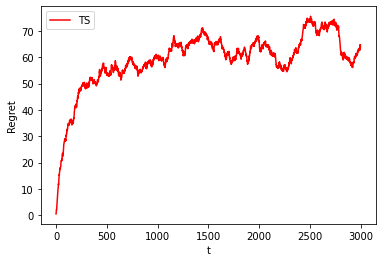

In [63]:
#arm_probabilities = np.array([0.45,0.35,0.25,0.15,0.05])
arm_probabilities = np.array([0.0,0.1,0.5,0.4,0.4])
position_probabilities=np.array([0.9,0.8,0.7,0.6,0.5,0.4])
n_pos=6
n_arms=5
bids=np.array([3,1,2,3,3,1,4,1,3,0])

T=3000
opt=(np.sort(arm_probabilities[bids])[::-1][:n_pos]*position_probabilities).sum()
print("opt is: ",opt)

n_experiments =7
ts_reward_per_experiment=[]
ucb_reward_per_experiment=[]

for e in range(0, n_experiments):
    env=Envirorment_PBM(n_positions=6,arms=bids,n_arms=n_arms, arm_probabilities= arm_probabilities, position_probabilities=position_probabilities)
    ts_learner=PBM_TS(5, bids, n_pos, position_probabilities, M=10)
    #ucb_learner=PBM_UCB(10, n_pos, position_probabilities, delta=4)

    for t in tqdm(range(T)):
        #gaussian tompson sampling
        pulled_arm=ts_learner.pull_arm()
        reward=env.round(pulled_arm)
        ts_learner.update(pulled_arm, reward)

        #GP tompson learner
        #pulled_arm=ucb_learner.pull_arm()
        #reward=env.round(pulled_arm)
        #ucb_learner.update(pulled_arm, reward)
    ts_reward_per_experiment.append(ts_learner.collected_rewards)
    #ucb_reward_per_experiment.append(ucb_learner.collected_rewards)

plt.figure(0)
plt.ylabel("Regret")
plt.xlabel("t")
plt.plot(np.cumsum(np.mean(opt-ts_reward_per_experiment,axis=0)), 'r')
#plt.plot(np.cumsum(np.mean(opt-ucb_reward_per_experiment,axis=0)), 'g')
plt.legend(["TS", "UCB"])
plt.show()
